In [1]:
import math
import glob
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm

import constants as c

from bmog import BMOG
from roi_extractor import regions_of_interest

from collections import OrderedDict

# Evaluation of BGS

_Do BGS and dump as `pickle`_

In [2]:
def imread_scaled(image_path, scale):
    image = cv2.imread(image_path)
    w,h,c = image.shape
    w,h = int(w*scale), int(h*scale)
    return cv2.resize(image, (h,w))


def save_rois_by_bgs(image_dir, bmog_threshold_l, bmog_postprocessing_size, dilation, min_size, init_frames, image_scale=1.0):
    found_rois_at_config = {}

    total_amount_iters = len(glob.glob(image_dir+"/*/*.jpg"))
    with tqdm(total=total_amount_iters) as pbar:
        for sequence in glob.glob(image_dir+"/*"):
            seq_name = os.path.basename(sequence)
            rois_for_sequence = {}

            bgs = BMOG(threshold_l=bmog_threshold_l, postprocessing_size=bmog_postprocessing_size)

            # initialize distributions
            for image_path in sorted(glob.glob(f'{sequence}/*.jpg'))[:init_frames]: 
                bgs.apply(imread_scaled(image_path, image_scale)) 
                pbar.update()

            # do roi extraction
            for image_path in sorted(glob.glob(f'{sequence}/*.jpg'))[init_frames:]:
                image_name = os.path.basename(image_path)[:-4] 
                image = imread_scaled(image_path, image_scale)

                #image = cv2.medianBlur(image, blur_kernel)
                fg_mask = bgs.apply(image)

                if dilation:
                    fg_mask = cv2.dilate(fg_mask,(5,5),
                                        iterations=dilation)

                rois = regions_of_interest(fg_mask,
                                        min_size=min_size,
                                        max_size=c.max_size*image_scale,
                                        aspect_ratio=c.aspect_ratio)

                rois_for_sequence[image_name] = []
                for roi in rois:
                    x,y,x2,y2 = roi
                    rois_for_sequence[image_name].append([x,y,x2,y2])
                pbar.update()
                #print(rois_for_sequence[image_name])
            found_rois_at_config[seq_name] = rois_for_sequence
    
    
    file_name = f'rois_threshold-{bmog_threshold_l}_postprocessing-{bmog_postprocessing_size}_dilation-{dilation}_min-{min_size}_scale-{image_scale}'
    with open(f'{c.output_dir_bgs}/{file_name}.pickle', 'wb') as handle:
        pickle.dump(found_rois_at_config, handle, protocol=4)

_Get Ground Truth Annotations and dump as `pickle`_

In [3]:
import xmltodict

def bbs_from_xml(xml):
    x = xmltodict.parse(xml)
    bbs = []
    
    if 'object' in x['annotation']:  # check for bbs in annoataion file
        for obj in x['annotation']['object']:
            if type(obj) == str: # only one obj in annotation
                obj = x['annotation']['object']
                bbs.append(extract_information(obj))
                break
            bbs.append(extract_information(obj))
    return bbs

def extract_information(xml_object):
    bndbox = xml_object['bndbox']
    bnd_box = [
            int(bndbox['xmin']),
            int(bndbox['ymin']),
            int(bndbox['xmax']),
            int(bndbox['ymax']),
            xml_object['name'],
            ]
    return bnd_box
    
def get_annotations_from_dir(annotation_dir):
    annotations = {}
    for file in glob.glob(f'{annotation_dir}/*.xml'):
        bbs = bbs_from_xml(open(file, 'rb'))
        file_base_name = (os.path.basename(file)[:-4])
        annotations[file_base_name] = bbs
    return annotations


gt_bbs = {}
for sequence in glob.glob(f'{c.bgs_sequences_dir}/*'):
    seq_name = os.path.basename(sequence)
    annotation_dir = os.path.join(c.bgs_annotation_dir, seq_name.partition('-')[0])
    
    gt_bbs[seq_name] = get_annotations_from_dir(annotation_dir)

with open('../output/gt_bbs.pickle', 'wb') as handle:
    pickle.dump(gt_bbs, handle, protocol=4)

## Comparing predicted with GTs

In [4]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


def weird_division(n, d):
    return n / d if d else 0


def statistics_for_rois(_found, _gt, iou_min, scale=1.0):
    iou_min_day, iou_night = iou_min

    results = {}

    # get every sequence of GTs
    for seq_name in _gt.keys():
        if 'day' in seq_name:
            iou_for_seq = iou_min_day
        else:
            iou_for_seq = iou_night
        
        not_even_found = 0
        should_have_been_found = 0
        FOUND_IN_SEQ = 0
        if seq_name in _found.keys():
            not_even_found = 0
            should_have_been_found = 0
            FOUND_IN_SEQ = 0

            # check every prediction for each frame
            for file_name, gts in _gt[seq_name].items():
                if file_name in _found[seq_name]:
                    for gt in gts:
                        gt = np.array(np.array(gt[0:4])*scale, dtype=int)

                        should_have_been_found += 1
                        found_intersecting_bb = False

                        # compare annotated roi with found rois, and stop when match is found
                        for found_roi in _found[seq_name][file_name]:
                            iou = bb_intersection_over_union(gt, found_roi)
                            if iou > iou_for_seq:
                                found_intersecting_bb = True

                        if not found_intersecting_bb:
                            not_even_found += 1

                    FOUND_IN_SEQ += len(_found[seq_name][file_name])
        results[seq_name] = not_even_found, should_have_been_found, FOUND_IN_SEQ
        #results_scale[seq_name] = 20, 100, 120
    return results

## Default BGS Parameters and Plot

In [ ]:
save_rois_by_bgs(c.bgs_sequences_dir, bmog_threshold_l=35, bmog_postprocessing_size=9, dilation=0, min_size=32, init_frames=c.frames_for_bgs_init, image_scale=1.0)
# and create copy 'bmog_renamed/rois-default.pickle'

- get statistics for `BGS` and plot them _(its getting dirty)_

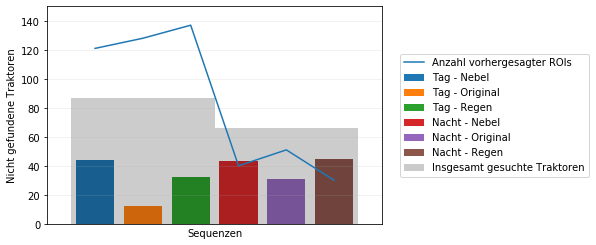

In [49]:
with open('../output/gt_bbs.pickle', 'rb') as handle:
    gt_bbs = pickle.load(handle)

iou_min = [0.5, 0.3]
    
statics = {}

with open(f"{c.output_dir_bgs}_optimized/rois-default.pickle", 'rb') as handle:
    found_rois = pickle.load(handle)
    statics = statistics_for_rois(found_rois, gt_bbs, iou_min=iou_min)

fig, ax = plt.subplots()

SEQS = len(found_rois.keys())
_found_amount = []
_not_found = []


not_found = []
total = []
seqs = []
been_found = []

pos = 0
for seq_name, res in sorted(statics.items()):
    not_found.append(res[0])
    total.append(res[1])
    been_found.append(res[-1])
    seqs.append(seq_name)

    # beautify names
    seq_name = seq_name.replace("_", " ").replace("-", " - ")[3:]
    seq_name = seq_name.replace("day", "Tag").replace("dawn", "Nacht")
    seq_name = seq_name.replace("orig", "Original").replace("fog", "Nebel").replace("rain", "Regen")

    plt.bar(pos, not_found[pos], label=seq_name)
    pos+=1

pos = np.arange(len(seqs))
bar_width = 0.9

plt.bar(pos, total, color='k', width=1, alpha=0.2, label="Insgesamt gesuchte Traktoren")
plt.plot(pos, been_found, label="Anzahl vorhergesagter ROIs")

#plt.title(f"BGS Start Konfiguration")
plt.xticks([], [])
plt.ylim(0, 150)
plt.xlim(-1, SEQS)

plt.ylabel("Nicht gefundene Traktoren")
plt.xlabel("Sequenzen")

plt.grid(axis='y', alpha=0.2, linestyle="-")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

plt.savefig(f"../visuals/bgs-start.png", dpi=300, bbox_inches='tight')

## BGS Optimization

In [43]:
save_rois_by_bgs(c.bgs_sequences_dir, bmog_threshold_l=35, bmog_postprocessing_size=9, dilation=0, min_size=15, init_frames=c.frames_for_bgs_init, image_scale=1.0) # minsize
save_rois_by_bgs(c.bgs_sequences_dir, bmog_threshold_l=35, bmog_postprocessing_size=15, dilation=0, min_size=15, init_frames=c.frames_for_bgs_init, image_scale=1.0) # postprocessing
save_rois_by_bgs(c.bgs_sequences_dir, bmog_threshold_l=35, bmog_postprocessing_size=15, dilation=15, min_size=15, init_frames=c.frames_for_bgs_init, image_scale=1.0) # dilate
save_rois_by_bgs(c.bgs_sequences_dir, bmog_threshold_l=25, bmog_postprocessing_size=15, dilation=15, min_size=15, init_frames=c.frames_for_bgs_init, image_scale=1.0) # th 25
save_rois_by_bgs(c.bgs_sequences_dir, bmog_threshold_l=20, bmog_postprocessing_size=15, dilation=15, min_size=15, init_frames=c.frames_for_bgs_init, image_scale=1.0) # th 20
save_rois_by_bgs(c.bgs_sequences_dir, bmog_threshold_l=15, bmog_postprocessing_size=15, dilation=15, min_size=15, init_frames=c.frames_for_bgs_init, image_scale=1.0) # th 15

# also rename and move to '../bmog_rename'

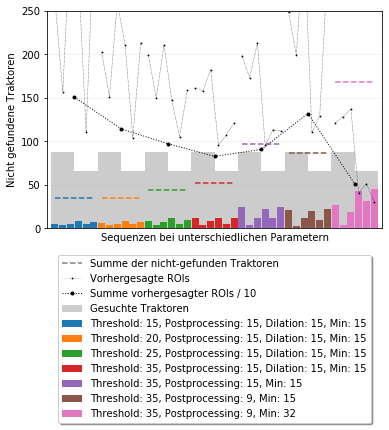

In [48]:
with open('../output/gt_bbs.pickle', 'rb') as handle:
    gt_bbs = pickle.load(handle)

    
iou_min = [0.4, 0.3]
    
statics = {}
for rois_config in glob.glob(f"{c.output_dir_bgs}_optimized/rois_*.pickle"):
    config = os.path.basename(rois_config)
    
    with open(rois_config, 'rb') as handle:
        found_rois = pickle.load(handle)  
        statics[config] = statistics_for_rois(found_rois, gt_bbs, iou_min=iou_min)



fig, ax = plt.subplots()

SEQS = len(found_rois.keys())
i = 1

_found_amount = []
_not_found = []

for config in sorted(statics.keys())[:]:
    not_found = []
    total = []
    seqs = []
    been_found = []

    for seq_name, res in sorted(statics[config].items()):
        if res[1]:
            not_found.append(res[0])
            total.append(res[1])
            been_found.append(res[-1])
            seqs.append(seq_name)

    pos = np.arange(len(seqs)*(i-1), len(seqs)*i)
    bar_width = 0.9

    label = config.replace("_", ", ").replace("-", ": ")[6:][:-7].title()

    plt.bar(pos, total, color='k', width=1, alpha=0.2, label="Gesuchte Traktoren")
    plt.bar(pos, not_found, label=label, width=bar_width)
    plt.plot([pos[0],pos[-1]], [sum(not_found), sum(not_found)], "--", color=f'C{i-1}', label="Summe der nicht-gefunden Traktoren")
    plt.plot(pos, np.divide(been_found,1), "ko:", label="Vorhergesagte ROIs", markersize=0.8, lw=0.5)

    i +=1

    _found_amount.append(sum(been_found))
    _not_found.append(sum(not_found))

plt.plot(np.arange(i-1)*SEQS+2.5, np.divide(_found_amount, 10), ":", marker='o', markersize=3, color='k', label="Summe vorhergesagter ROIs / 10", lw=1)

#plt.title(f"BGS Optimiziation")
plt.xticks([], [])
plt.ylim(0, 250)
plt.xlim(-1, (i-1)*SEQS)

plt.xlabel("Sequenzen bei unterschiedlichen Parametern")
plt.ylabel("Nicht gefundene Traktoren")

plt.grid(axis='y', alpha=0.2, linestyle="-")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(),
            loc='upper center', bbox_to_anchor=(0.5, -0.10),
            fancybox=True, shadow=True, ncol=1)

leg = ax.get_legend()
leg.legendHandles[0].set_color('C7')
leg.legendHandles[1].set_color('C7')

plt.savefig(f"../visuals/bgs-opti.png", dpi=300, bbox_inches='tight')

## Test different scales for `min-obj-size` determination

In [39]:
postprocessors = np.flip([13,13,11,9,7,7,5,5,5]) # must be odd, thus cannot simply scale them

for scale, post in zip(np.around(np.linspace(0.1, 1, 9, endpoint=False), 1), postprocessors):
    if scale < 0.6:
        save_rois_by_bgs(c.bgs_sequences_dir, bmog_threshold_l=20,
                         bmog_postprocessing_size=post,
                         dilation=post,
                         min_size=post,
                         init_frames=c.frames_for_bgs_init,
                         image_scale=scale)
# and move to 'output/bmog_scaling' + number them!

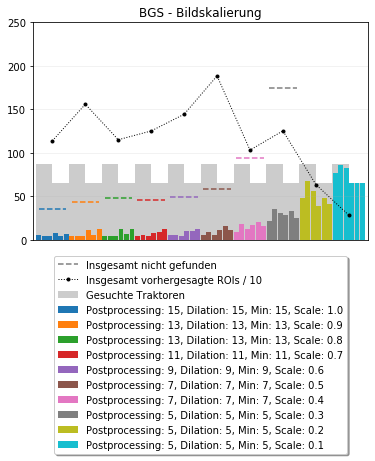

In [41]:
with open('../output/gt_bbs.pickle', 'rb') as handle:
    gt_bbs = pickle.load(handle)


iou_min = [0.4, 0.3]

statics = {}
for rois_config_path in glob.glob(f"{c.output_dir_bgs}_scaling/*_rois_*.pickle"):
    config_name = os.path.basename(rois_config_path)
    
    # last param (-1), cut '.pickle', get number
    scale = float(config_name.split('_')[-1][:-7].split('-')[-1])
    
    with open(rois_config_path, 'rb') as handle:
        found_rois = pickle.load(handle)
        statics[config_name] = statistics_for_rois(found_rois, gt_bbs, iou_min=iou_min, scale=scale)


fig, ax = plt.subplots()

SEQS = len(found_rois.keys())
i = 1

_found_amount = []
_not_found = []

for config_name in sorted(statics.keys())[:]:
    not_found = []
    total = []
    seqs = []
    been_found = []

    for seq_name, res in sorted(statics[config_name].items()):
        if res[1]:
            not_found.append(res[0])
            total.append(res[1])
            been_found.append(res[-1])
            seqs.append(seq_name)

    pos = np.arange(len(seqs)*(i-1), len(seqs)*i)
    bar_width = 0.9

    label = config_name.replace("_", ", ").replace("-", ": ")[10:][:-7].title()

    plt.bar(pos, total, color='k', width=1, alpha=0.2, label="Gesuchte Traktoren")
    plt.bar(pos, not_found, label=label, width=bar_width)
    plt.plot([pos[0],pos[-1]], [sum(not_found), sum(not_found)], "--", color=f'C{i-1}', label="Insgesamt nicht gefunden")
    #plt.plot(pos, np.divide(been_found,1), ":", label="Vorhergesagte ROIs")

    i +=1

    _found_amount.append(sum(been_found))
    _not_found.append(sum(not_found))

plt.plot(np.arange(i-1)*SEQS+2.5, np.divide(_found_amount, 10), ":", marker='o', markersize=3, color='k', label="Insgesamt vorhergesagte ROIs / 10", lw=1)

plt.title(f"BGS - Bildskalierung")
plt.xticks([], [])
plt.ylim(0, 250)
plt.xlim(-1, (i-1)*SEQS)

plt.grid(axis='y', alpha=0.2, linestyle="-")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(),
            loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=1)

leg = ax.get_legend()
leg.legendHandles[0].set_color('C7')
#leg.legendHandles[1].set_color('C7')

plt.savefig(f"../visuals/bgs-scaling.png", dpi=300, bbox_inches='tight')